# Exercise 6 + Homework 3: MLPs + Dropout + CNNs

Much of this was taken from DS-GA 1011 course from last semester.

### Data things

We're doing a sentiment classification task. So first load the Stanford Sentiment Treebank data.

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import re
import random

random.seed(1)
sst_home = 'data/trees'

# Let's do 2-way positive/negative classification instead of 5-way
easy_label_map = {0:0, 1:0, 2:None, 3:1, 4:1}
    # so labels of 0 and 1 in te 5-wayclassificaiton are 0 in the 2-way. 3 and 4 are 1, and 2 is none
    # because we don't have a neautral class. 

PADDING = "<PAD>"
UNKNOWN = "<UNK>"
max_seq_length = 20

def load_sst_data(path):
    data = []
    with open(path) as f:
        for i, line in enumerate(f): 
            example = {}
            example['label'] = easy_label_map[int(line[1])]
            if example['label'] is None:
                continue
            
            # Strip out the parse information and the phrase labels---we don't need those here
            text = re.sub(r'\s*(\(\d)|(\))\s*', '', line)
            example['text'] = text[1:]
            data.append(example)

    random.seed(1)
    random.shuffle(data)
    return data
     
training_set = load_sst_data(sst_home + '/train.txt')
dev_set = load_sst_data(sst_home + '/dev.txt')
test_set = load_sst_data(sst_home + '/test.txt')

And extract bag-of-words feature vectors. For speed, we'll only use words that appear at least 25 times in the training set, leaving us with |V|=1254.

In [2]:
import collections
import numpy as np

def tokenize(string):
    return string.split()

def build_dictionary(training_datasets):
    """
    Extract vocabulary and build dictionary.
    """  
    word_counter = collections.Counter()
    for i, dataset in enumerate(training_datasets):
        for example in dataset:
            word_counter.update(tokenize(example['text']))
        
    vocabulary = set([word for word in word_counter])
    vocabulary = list(vocabulary)
    vocabulary = [PADDING, UNKNOWN] + vocabulary
        
    word_indices = dict(zip(vocabulary, range(len(vocabulary))))

    return word_indices, len(vocabulary)

def sentences_to_padded_index_sequences(word_indices, datasets):
    """
    Annotate datasets with feature vectors. Adding right-sided padding. 
    """
    for i, dataset in enumerate(datasets):
        for example in dataset:
            example['text_index_sequence'] = torch.zeros(max_seq_length)

            token_sequence = tokenize(example['text'])
            padding = max_seq_length - len(token_sequence)

            for i in range(max_seq_length):
                if i >= len(token_sequence):
                    index = word_indices[PADDING]
                    pass
                else:
                    if token_sequence[i] in word_indices:
                        index = word_indices[token_sequence[i]]
                    else:
                        index = word_indices[UNKNOWN]
                example['text_index_sequence'][i] = index

            example['text_index_sequence'] = example['text_index_sequence'].long().view(1,-1)
            example['label'] = torch.LongTensor([example['label']])


word_to_ix, vocab_size = build_dictionary([training_set])
sentences_to_padded_index_sequences(word_to_ix, [training_set, dev_set, test_set])

We want to feed data to our model in mini-batches so we need a data iterator that will "batchify" the data. We 

In [4]:
# This is the iterator we'll use during training. 
# It's a generator that gives you one batch at a time.
def data_iter(source, batch_size):
    dataset_size = len(source)
    start = -1 * batch_size
    order = list(range(dataset_size))
    random.shuffle(order)

    while True:
        start += batch_size
        if start > dataset_size - batch_size:
            # Start another epoch.
            start = 0
            random.shuffle(order)   
        batch_indices = order[start:start + batch_size]
        yield [source[index] for index in batch_indices]

# This is the iterator we use when we're evaluating our model. 
# It gives a list of batches that you can then iterate through.
def eval_iter(source, batch_size):
    batches = []
    dataset_size = len(source)
    start = -1 * batch_size
    order = list(range(dataset_size))
    random.shuffle(order)

    while start < dataset_size - batch_size:
        start += batch_size
        batch_indices = order[start:start + batch_size]
        batch = [source[index] for index in batch_indices]
        batches.append(batch)
        
    return batches

# The following function gives batches of vectors and labels, 
# these are the inputs to your model and loss function
def get_batch(batch):
    vectors = []
    labels = []
    for dict in batch:
        vectors.append(dict["text_index_sequence"])
        labels.append(dict["label"])
    return vectors, labels


### Model time!

We need to define an evaluation function,

In [5]:
def evaluate(model, data_iter):
    model.eval()
    correct = 0
    total = 0
    for i in range(len(data_iter)):
        vectors, labels = get_batch(data_iter[i])
        vectors = Variable(torch.stack(vectors).squeeze())
        labels = torch.stack(labels).squeeze()
        output = model(vectors)
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
    return correct / float(total)

Below is a multilayer perceptron classifier.

What hyperparameters do you think would work well?

In [6]:
# A Multi-Layer Perceptron (MLP)
class MLPClassifier(nn.Module): # inheriting from nn.Module!
    
    def __init__(self, input_size, embedding_dim, hidden_dim, num_labels, dropout_prob):
        super(MLPClassifier, self).__init__()
        
        self.embed = nn.Embedding(input_size, embedding_dim, padding_idx=0)
        self.dropout = nn.Dropout(p=dropout_prob)
            
        self.linear_1 = nn.Linear(embedding_dim, hidden_dim) 
        self.linear_2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear_3 = nn.Linear(hidden_dim, num_labels)
        self.init_weights()
        
    def forward(self, x):
        # Pass the input through your layers in order
        out = self.embed(x)
        out = self.dropout(out)
        out = torch.sum(out, dim=1)
        out = F.relu(self.linear_1(out))
        out = F.relu(self.linear_2(out))
        out = self.dropout(self.linear_3(out))
        return out

    def init_weights(self):
        initrange = 0.1
        lin_layers = [self.linear_1, self.linear_2]
        em_layer = [self.embed]
     
        for layer in lin_layers+em_layer:
            layer.weight.data.uniform_(-initrange, initrange)
            if layer in lin_layers:
                layer.bias.data.fill_(0)

We now define our training loop,

In [7]:
def training_loop(model, loss, optimizer, training_iter, dev_iter, train_eval_iter):
    step = 0
    legend = []
    for i in range(num_train_steps):
        model.train()
        vectors, labels = get_batch(next(training_iter))
        vectors = Variable(torch.stack(vectors).squeeze())
        labels = Variable(torch.stack(labels).squeeze())

        model.zero_grad()
        output = model(vectors)

        lossy = loss(output, labels)
        lossy.backward()
        optimizer.step()

        if step % 100 == 0:
            legend.append([evaluate(model, train_eval_iter),evaluate(model, dev_iter)])
            print( "Step %i; Loss %f; Train acc: %f; Dev acc %f" 
                %(step, lossy.data[0], evaluate(model, train_eval_iter), evaluate(model, dev_iter)))

        step += 1
    return legend

Let's define our hyperparameters

In [8]:
# Hyper Parameters 
input_size = vocab_size
num_labels = 2
batch_size = 32
num_train_steps = 1000

Modify these hyperparameters to try to achieve approximately 80% dev accuracy.

In [9]:
hidden_dim = 20
embedding_dim = 300
learning_rate = 0.001
dropout_prob = 0.5

Finally, we can build and train our model!

In [11]:
def hyperTuningCBOW(hidden_dim,embedding_dim,learning_rate,dropout_prob,legendCBOW):
    
    model = MLPClassifier(input_size, embedding_dim, hidden_dim, num_labels, dropout_prob)

    # Loss and Optimizer
    loss = nn.CrossEntropyLoss()  
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    training_iter = data_iter(training_set, batch_size)
    train_eval_iter = eval_iter(training_set[0:500], batch_size)
    dev_iter = eval_iter(dev_set[0:500], batch_size)
    legendCBOW[hidden_dim] = training_loop(model, loss, optimizer, training_iter, dev_iter, train_eval_iter)

In [137]:
legendCBOW = {}
for h in range(5,50,5):
    hyperTuningCBOW(h,embedding_dim,learning_rate,dropout_prob,legendCBOW)
    print(legendCBOW)

Step 0; Loss 0.762861; Train acc: 0.486000; Dev acc 0.472000
Step 100; Loss 0.758078; Train acc: 0.532000; Dev acc 0.534000
Step 200; Loss 0.624345; Train acc: 0.618000; Dev acc 0.640000
Step 300; Loss 0.570672; Train acc: 0.774000; Dev acc 0.754000
Step 400; Loss 0.613060; Train acc: 0.854000; Dev acc 0.780000
Step 500; Loss 0.365938; Train acc: 0.886000; Dev acc 0.782000
Step 600; Loss 0.457649; Train acc: 0.908000; Dev acc 0.790000
Step 700; Loss 0.393451; Train acc: 0.934000; Dev acc 0.786000


KeyboardInterrupt: 

Let's see how it performs on the held out test set,

In [86]:
# Test the model
test_iter = eval_iter(test_set, batch_size)
test_acc = evaluate(model, test_iter)
print('Accuracy of the CBOW on the test data: %f' % (test_acc))

Accuracy of the CBOW on the test data: 0.781988


<br>
This model does okay. It doesn't do that well. Lets try and define a Convolutional Neural Network to try and improve performance.

In [12]:
class TextCNN(nn.Module):
    def __init__(self, input_size, embedding_dim, window_size, n_filters, num_labels, dropout_prob):
        super(TextCNN, self).__init__()
        
        self.embed = nn.Embedding(input_size, embedding_dim, padding_idx=0)
        self.dropout = nn.Dropout(p = dropout_prob)
        self.dropout2 = nn.Dropout(p = dropout_prob)
        self.conv1 = nn.Conv2d(1, n_filters, (window_size, embedding_dim)) 
        self.fc1 = nn.Linear(n_filters, num_labels)
        self.init_weights()
        
    def forward(self, x):
        # Pass the input through your layers in order
        out = self.embed(x)
        out = self.dropout(out)
        out = out.unsqueeze(1)
        out = self.conv1(out).squeeze(3)
        out = F.relu(out)
        out = F.max_pool1d(out, out.size(2)).squeeze(2)
        out = self.fc1(self.dropout2(out))
        return out

    def init_weights(self):
        initrange = 0.1
        lin_layers = [self.fc1]
        em_layer = [self.embed]
     
        for layer in lin_layers+em_layer:
            layer.weight.data.uniform_(-initrange, initrange)
            if layer in lin_layers:
                layer.bias.data.fill_(0)

Lets train our Conv Net. Lets redefine the hyperparameters here. You need to modify these as well! Try to achieve approximately 80% dev accuracy.

In [13]:
window_size = 5
n_filters = 10
embedding_dim = 100
learning_rate = 0.001
dropout_prob = 0.5

Lets build and train this model:

In [106]:
window_size = 5
n_filters = 10
embedding_dim = 100
learning_rate = 0.001
dropout_prob = 0.5

def hyperTuningCNN(hidden_dim,embedding_dim,learning_rate,dropout_prob,legendCNN):

    cnn_model = TextCNN(input_size, embedding_dim, window_size, n_filters, num_labels, dropout_prob)

    # Loss and Optimizer
    loss = nn.CrossEntropyLoss()  
    optimizer = torch.optim.Adam(cnn_model.parameters(), lr=learning_rate)

    # Train the model
    training_iter = data_iter(training_set, batch_size)
    train_eval_iter = eval_iter(training_set[0:500], batch_size)
    dev_iter = eval_iter(dev_set[0:500], batch_size)
    legendCNN[hidden_dim] = training_loop(cnn_model, loss, optimizer, training_iter, dev_iter, train_eval_iter)

Step 0; Loss 0.692502; Train acc: 0.518000; Dev acc 0.532000
Step 100; Loss 0.695913; Train acc: 0.514000; Dev acc 0.528000
Step 200; Loss 0.692318; Train acc: 0.514000; Dev acc 0.528000
Step 300; Loss 0.686682; Train acc: 0.636000; Dev acc 0.632000
Step 400; Loss 0.714703; Train acc: 0.684000; Dev acc 0.676000
Step 500; Loss 0.644465; Train acc: 0.788000; Dev acc 0.730000
Step 600; Loss 0.478142; Train acc: 0.856000; Dev acc 0.780000
Step 700; Loss 0.580567; Train acc: 0.886000; Dev acc 0.802000
Step 800; Loss 0.481057; Train acc: 0.908000; Dev acc 0.802000
Step 900; Loss 0.278241; Train acc: 0.916000; Dev acc 0.796000


In [ ]:
legendCNN = {}
for h in range(5,50,5):
    hyperTuningCNN(h,embedding_dim,learning_rate,dropout_prob,legendCBOW)
    print(legendCNN)

Lets evaluate this on the held out test set

In [111]:
# Test the model
test_iter = eval_iter(test_set, batch_size)
test_acc = evaluate(cnn_model, test_iter)
print('Accuracy of the CNN model on the test data: %f' % (test_acc))

Accuracy of the CNN model on the test data: 0.774849


# Homework 3 (10pts)

### Please construct all of your plots in the ipython notebook using something like matplotlib. Provide all answers in the ipython notebook. We will not grade anything other than the ipython notebook

Questions:

1. Provide plots of varying hidden_dim, embedding_dim, LR, and dropout for deep CBOW (0.75pts each). 
2. Describe how each hyperparameter affects performance on train and dev (1.5pts total).
3. Provide plots of varying embedding_dim, window_size, num_filters, LR, and dropout for CNN (0.6pts for each HP).
4. Describe how each hyperparameter affects performance on train and dev (1.5pts total).
5. Write down an hyperparameter configuration for CBOW that achieves 80 dev within the first 1000 train steps. Make sure this configuration is run in your ipython notebook when it is submitted (0.5pts).
6. Write down an hyperparameter configuration for CNN that achieves 80 dev within the first 1000 train steps. Make sure this configuration is run in your ipython notebook when it is submitted (0.5pts).

In [24]:
import pickle
f = open('CBOW_P1')
cbow = pickle.load(f)
print(cbow)

defaultdict(<type 'dict'>, {u'dropout_prob': {0.5: [[0.484, 0.472], [0.486, 0.472], [0.52, 0.528], [0.486, 0.474], [0.516, 0.528], [0.486, 0.472], [0.486, 0.472], [0.514, 0.528], [0.514, 0.528], [0.514, 0.528]], 0.20000000000000001: [[0.486, 0.472], [0.514, 0.528], [0.514, 0.528], [0.484, 0.47], [0.486, 0.472], [0.514, 0.528], [0.514, 0.528], [0.514, 0.528], [0.486, 0.472], [0.486, 0.472]], 0.40000000000000002: [[0.46, 0.508], [0.514, 0.528], [0.514, 0.528], [0.514, 0.528], [0.514, 0.528], [0.486, 0.472], [0.514, 0.528], [0.514, 0.528], [0.514, 0.528], [0.486, 0.472]], 0.80000000000000004: [[0.514, 0.53], [0.486, 0.472], [0.514, 0.528], [0.486, 0.472], [0.486, 0.472], [0.486, 0.472], [0.486, 0.472], [0.514, 0.528], [0.514, 0.528], [0.486, 0.472]], 0.30000000000000004: [[0.486, 0.472], [0.488, 0.472], [0.488, 0.476], [0.516, 0.528], [0.486, 0.472], [0.514, 0.528], [0.486, 0.472], [0.486, 0.472], [0.514, 0.528], [0.514, 0.528]], 0.59999999999999998: [[0.514, 0.528], [0.514, 0.53], [0.514

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

In [44]:
sorted(cbow['hidden_dim'])

[5, 10, 15, 20, 25, 30, 35, 40, 45]

In [53]:
def getSimpleLastValues(dictionary,var):
    x = list(keys for keys in sorted(dictionary[var]))
    y = [dictionary[var][key][-1][1] for key in sorted(dictionary[var])]
    return x, y
print(cbow['hidden_dim'])
x,y = getSimpleLastValues(cbow,'hidden_dim')
print('--',x)
print('--',y)

{35: [[0.486, 0.472], [0.488, 0.472], [0.514, 0.528], [0.518, 0.532], [0.514, 0.528], [0.514, 0.528], [0.486, 0.472], [0.486, 0.472], [0.514, 0.528], [0.514, 0.528]], 5: [[0.506, 0.478], [0.514, 0.528], [0.514, 0.528], [0.514, 0.528], [0.486, 0.472], [0.514, 0.528], [0.514, 0.528], [0.514, 0.528], [0.514, 0.528], [0.514, 0.528]], 40: [[0.506, 0.512], [0.516, 0.528], [0.516, 0.528], [0.51, 0.522], [0.514, 0.528], [0.514, 0.528], [0.514, 0.528], [0.486, 0.472], [0.514, 0.528], [0.486, 0.472]], 10: [[0.478, 0.474], [0.514, 0.528], [0.486, 0.472], [0.486, 0.472], [0.486, 0.472], [0.516, 0.528], [0.514, 0.528], [0.486, 0.472], [0.514, 0.528], [0.486, 0.472]], 45: [[0.484, 0.48], [0.514, 0.53], [0.516, 0.528], [0.514, 0.528], [0.486, 0.472], [0.484, 0.472], [0.514, 0.528], [0.486, 0.472], [0.514, 0.528], [0.486, 0.472]], 15: [[0.48, 0.474], [0.51, 0.526], [0.512, 0.54], [0.484, 0.47], [0.486, 0.472], [0.514, 0.528], [0.486, 0.472], [0.514, 0.528], [0.514, 0.528], [0.514, 0.528]], 20: [[0.508

In [40]:
k = 5
print([it[1] for it in cbow['hidden_dim'][k]],cbow['hidden_dim'][k])

([0.478, 0.528, 0.528, 0.528, 0.472, 0.528, 0.528, 0.528, 0.528, 0.528], [[0.506, 0.478], [0.514, 0.528], [0.514, 0.528], [0.514, 0.528], [0.486, 0.472], [0.514, 0.528], [0.514, 0.528], [0.514, 0.528], [0.514, 0.528], [0.514, 0.528]])


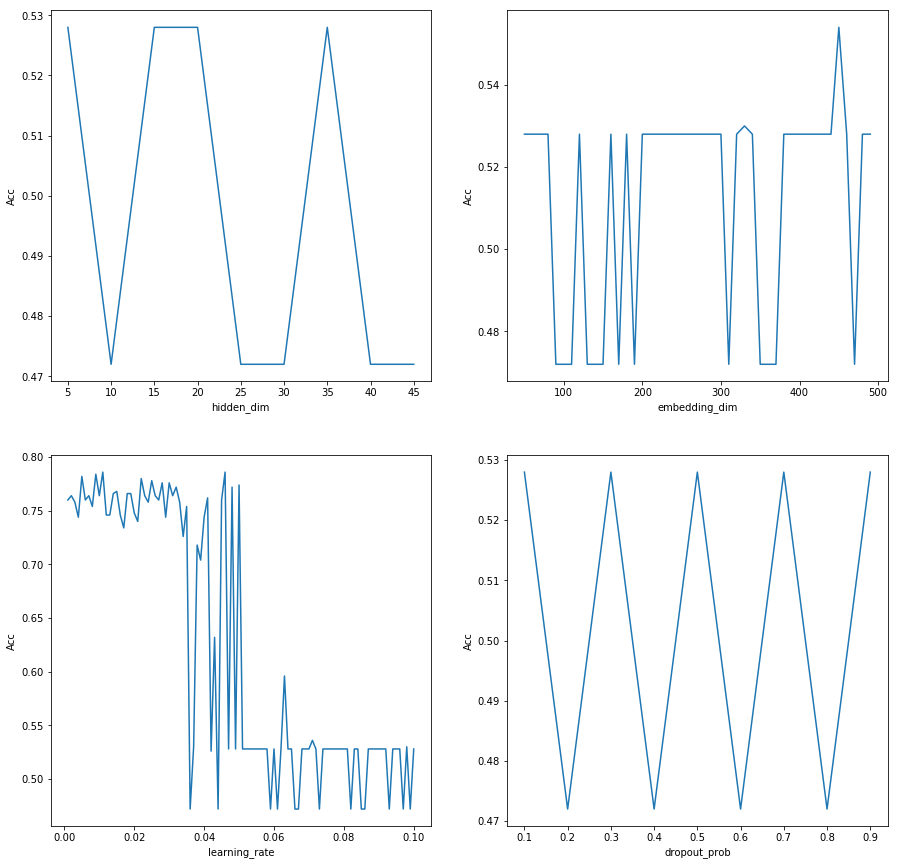

In [66]:
hypers = ['hidden_dim','embedding_dim','learning_rate','dropout_prob']
plt.figure(1,figsize=(15, 15))
for idx,var in enumerate(hypers):
    plt.subplot(2, 2, idx+1)
    x,y = getSimpleLastValues(cbow,var)
    plt.plot(x,y)
    plt.ylabel('Acc')
    plt.xlabel(var)

In [51]:
import pickle
f = open('CNN_P1')
cnn = pickle.load(f)
print(cnn)

defaultdict(<type 'dict'>, {u'learning_rate': {0.088000000000000009: [[0.486, 0.472], [0.58, 0.584], [0.52, 0.514], [0.554, 0.558], [0.566, 0.548], [0.642, 0.58], [0.606, 0.542], [0.732, 0.622], [0.682, 0.61], [0.684, 0.594]], 0.022000000000000002: [[0.514, 0.528], [0.746, 0.722], [0.69, 0.666], [0.858, 0.738], [0.9, 0.77], [0.922, 0.74], [0.944, 0.74], [0.956, 0.752], [0.938, 0.75], [0.96, 0.744]], 0.098000000000000004: [[0.486, 0.472], [0.534, 0.54], [0.51, 0.51], [0.594, 0.556], [0.52, 0.524], [0.484, 0.484], [0.49, 0.562], [0.602, 0.58], [0.59, 0.574], [0.658, 0.582]], 0.095000000000000001: [[0.486, 0.472], [0.568, 0.592], [0.612, 0.568], [0.532, 0.528], [0.586, 0.588], [0.662, 0.61], [0.692, 0.608], [0.656, 0.61], [0.708, 0.602], [0.696, 0.586]], 0.030000000000000002: [[0.486, 0.472], [0.654, 0.638], [0.722, 0.724], [0.68, 0.65], [0.784, 0.714], [0.858, 0.762], [0.924, 0.754], [0.934, 0.752], [0.902, 0.738], [0.96, 0.762]], 0.016: [[0.514, 0.528], [0.718, 0.732], [0.8, 0.76], [0.7

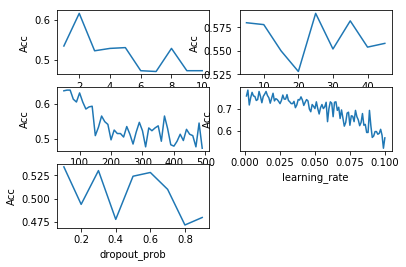

In [55]:
hypers = ['window_size','n_filters','embedding_dim','learning_rate','dropout_prob']

for idx,var in enumerate(hypers):
    plt.subplot(3, 2, idx+1)
    x,y = getSimpleLastValues(cnn,var)
    plt.plot(x,y)
    plt.ylabel('Acc')
    plt.xlabel(var)

In [75]:
def getHistoryValues(dictionary,var):
    numOfVals = list(keys for keys in sorted(cbow[var]))
    x = list(range(10))
    ys = []
    for k in numOfVals:
        ys.append([hist[1] for hist in cbow[var][k]])
    return x,ys,numOfVals

print(cbow['hidden_dim'])

x,y,n = getHistoryValues(cbow,'hidden_dim')
print('--',x)
print('--',y)

{35: [[0.486, 0.472], [0.488, 0.472], [0.514, 0.528], [0.518, 0.532], [0.514, 0.528], [0.514, 0.528], [0.486, 0.472], [0.486, 0.472], [0.514, 0.528], [0.514, 0.528]], 5: [[0.506, 0.478], [0.514, 0.528], [0.514, 0.528], [0.514, 0.528], [0.486, 0.472], [0.514, 0.528], [0.514, 0.528], [0.514, 0.528], [0.514, 0.528], [0.514, 0.528]], 40: [[0.506, 0.512], [0.516, 0.528], [0.516, 0.528], [0.51, 0.522], [0.514, 0.528], [0.514, 0.528], [0.514, 0.528], [0.486, 0.472], [0.514, 0.528], [0.486, 0.472]], 10: [[0.478, 0.474], [0.514, 0.528], [0.486, 0.472], [0.486, 0.472], [0.486, 0.472], [0.516, 0.528], [0.514, 0.528], [0.486, 0.472], [0.514, 0.528], [0.486, 0.472]], 45: [[0.484, 0.48], [0.514, 0.53], [0.516, 0.528], [0.514, 0.528], [0.486, 0.472], [0.484, 0.472], [0.514, 0.528], [0.486, 0.472], [0.514, 0.528], [0.486, 0.472]], 15: [[0.48, 0.474], [0.51, 0.526], [0.512, 0.54], [0.484, 0.47], [0.486, 0.472], [0.514, 0.528], [0.486, 0.472], [0.514, 0.528], [0.514, 0.528], [0.514, 0.528]], 20: [[0.508

('Plotting accuracy history across variables (different lines) with respect to train steps - ', 'hidden_dim')
('Plotting accuracy history across variables (different lines) with respect to train steps - ', 'embedding_dim')
('Plotting accuracy history across variables (different lines) with respect to train steps - ', 'learning_rate')
('Plotting accuracy history across variables (different lines) with respect to train steps - ', 'dropout_prob')


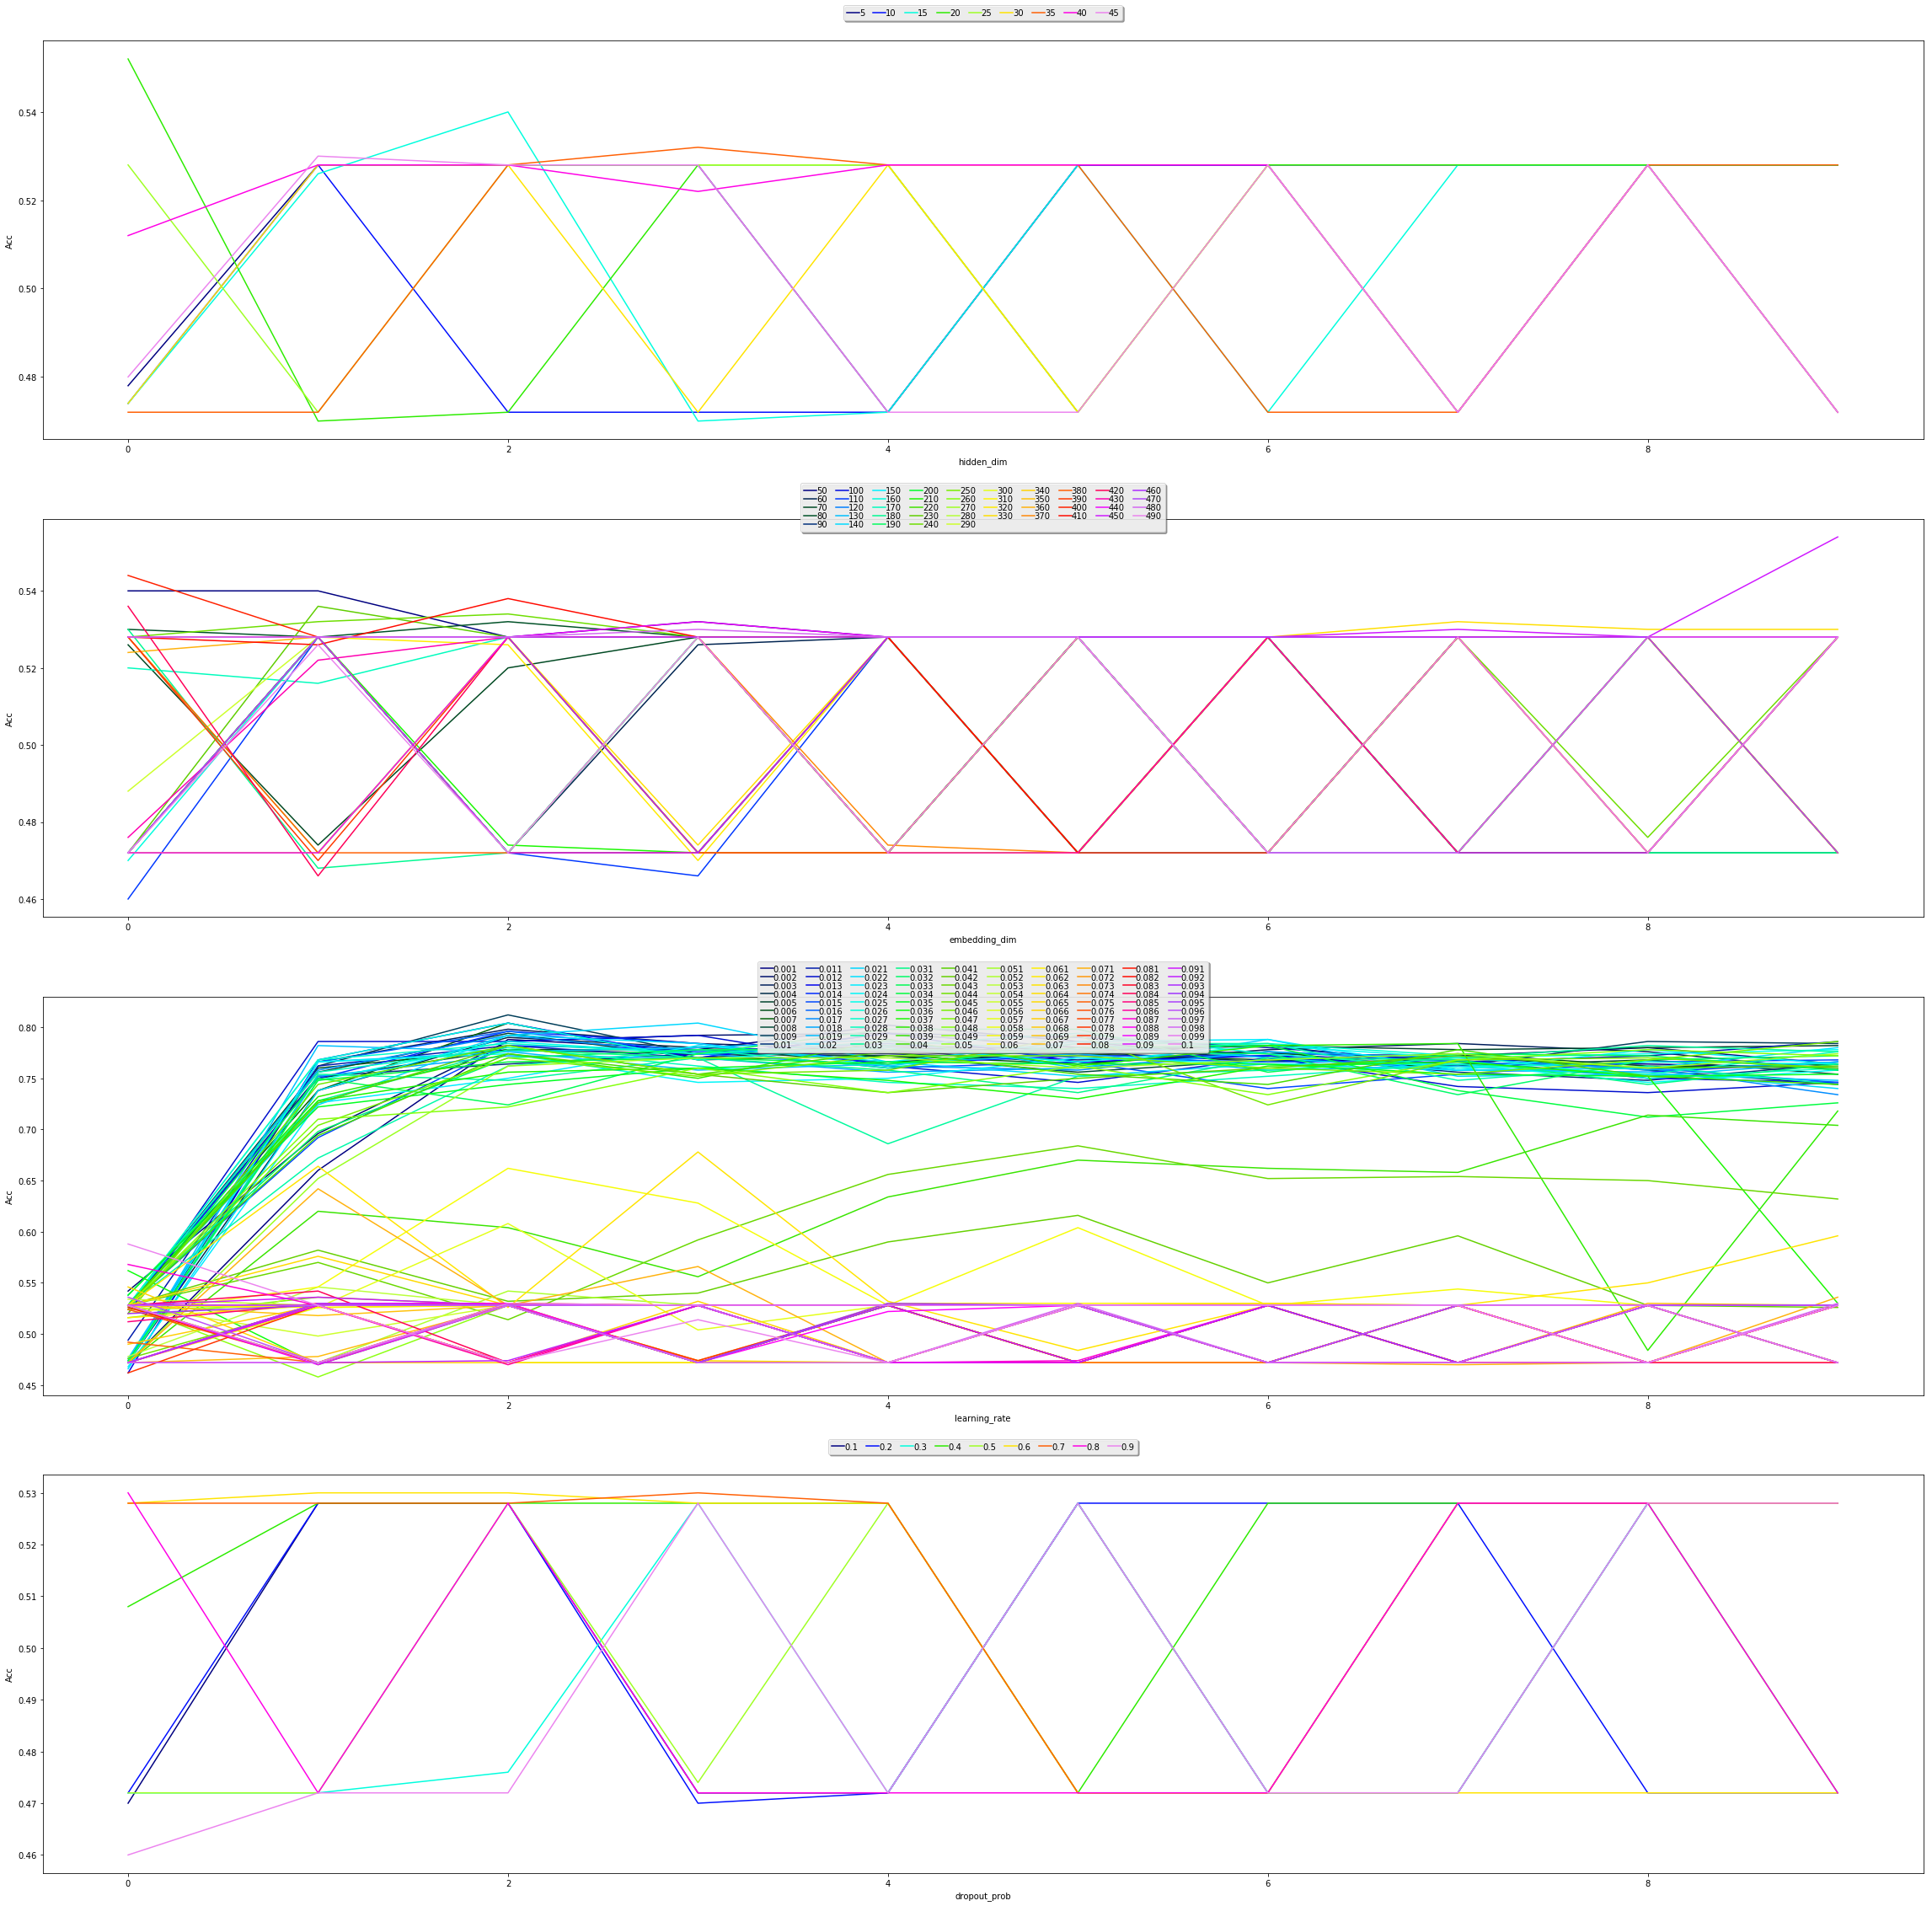

In [77]:
# num_plots = 20
# colormap = plt.cm.gist_ncar
# plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, num_plots)])

# x = np.arange(10)
# labels = []
# for i in range(1, num_plots + 1):
#     plt.plot(x, i * x + 5 * i)
#     labels.append(r'$y = %ix + %i$' % (i, 5*i))

# # I'm basically just demonstrating several different legend options here...
# plt.legend(labels, ncol=4, loc='upper center', 
#            bbox_to_anchor=[0.5, 1.1], 
#            columnspacing=1.0, labelspacing=0.0,
#            handletextpad=0.0, handlelength=1.5,
#            fancybox=True, shadow=True)

hypers = ['hidden_dim','embedding_dim','learning_rate','dropout_prob']
plt.figure(1,figsize=(40, 40))
for idx,var in enumerate(hypers):
    print("Plotting accuracy history across variables (different lines) with respect to train steps - ",var)
    x,ys,numOfVals = getHistoryValues(cbow,var)
    labels = [str(val) for val in numOfVals]
    plt.subplot(4, 1, idx+1)
    num_plots = len(ys)
    colormap = plt.cm.gist_ncar
    plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, num_plots)])

    for y in ys:
        plt.plot(x,y)

    plt.ylabel('Acc')
    plt.xlabel(var)
    
    plt.legend(labels, ncol=10, loc='upper center', 
           bbox_to_anchor=[0.5, 1.1], 
           columnspacing=1.0, labelspacing=0.0,
           handletextpad=0.0, handlelength=1.5,
           fancybox=True, shadow=True)



Plotting CNN history values----------------------------------
('Plotting accuracy history across variables (different lines) with respect to train steps - ', 'window_size')
('Plotting accuracy history across variables (different lines) with respect to train steps - ', 'n_filters')
('Plotting accuracy history across variables (different lines) with respect to train steps - ', 'embedding_dim')
('Plotting accuracy history across variables (different lines) with respect to train steps - ', 'learning_rate')
('Plotting accuracy history across variables (different lines) with respect to train steps - ', 'dropout_prob')


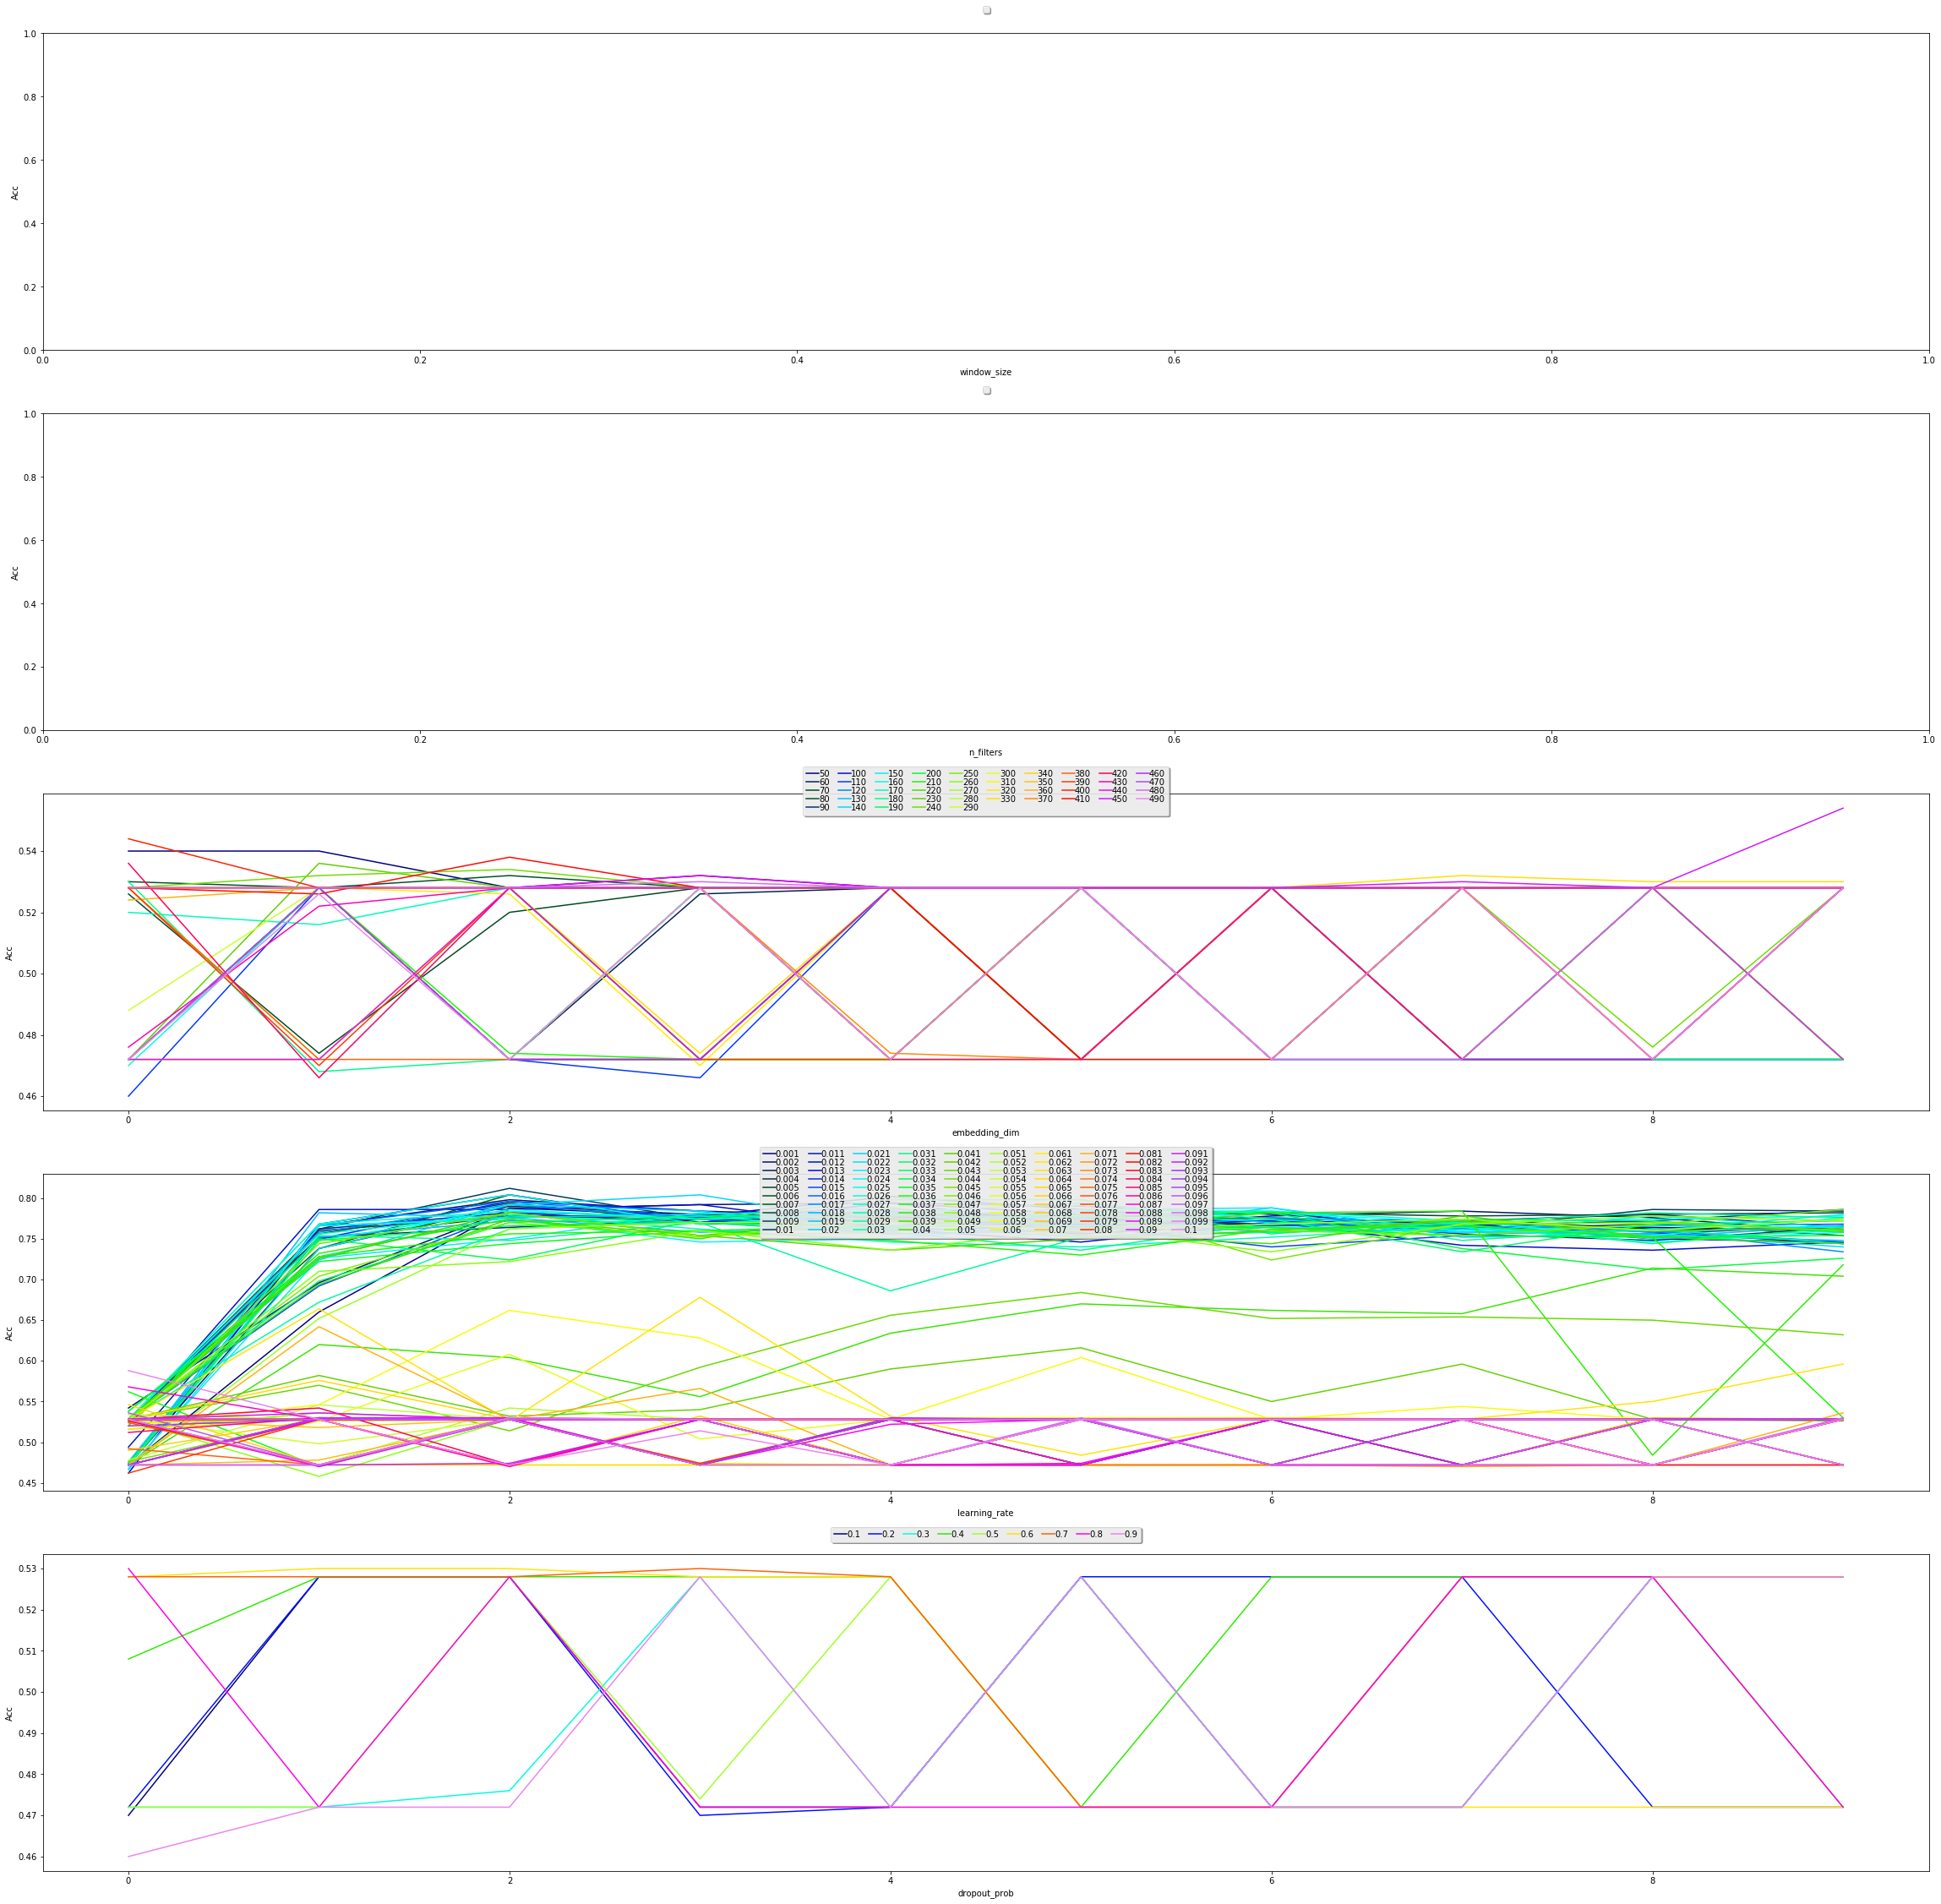

In [78]:
print("Plotting CNN history values----------------------------------")

hypers = ['window_size','n_filters','embedding_dim','learning_rate','dropout_prob']
plt.figure(1,figsize=(40, 40))
for idx,var in enumerate(hypers):
    print("Plotting accuracy history across variables (different lines) with respect to train steps - ",var)
    x,ys,numOfVals = getHistoryValues(cnn,var)
    labels = [str(val) for val in numOfVals]
    plt.subplot(5, 1, idx+1)
    num_plots = len(ys)
    colormap = plt.cm.gist_ncar
    plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, num_plots)])

    for y in ys:
        plt.plot(x,y)

    plt.ylabel('Acc')
    plt.xlabel(var)
    
    plt.legend(labels, ncol=10, loc='upper center', 
           bbox_to_anchor=[0.5, 1.1], 
           columnspacing=1.0, labelspacing=0.0,
           handletextpad=0.0, handlelength=1.5,
           fancybox=True, shadow=True)